In [1]:
!git clone https://github.com/crigroup/osr_course_pkgs.git osr_course_pkgs

Cloning into 'osr_course_pkgs'...
remote: Enumerating objects: 327, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 327 (delta 4), reused 16 (delta 4), pack-reused 309 (from 1)
Receiving objects: 100% (327/327), 32.13 MiB | 15.55 MiB/s, done.
Resolving deltas: 100% (120/120), done.


In [2]:
import sys
sys.path.append('/content/osr_course_pkgs/osr_examples/scripts') # Replace '/content/' if the repository is cloned to a different location

In [37]:
def is_line_segment_intersecting(x1, y1, x2, y2, x3, y3, x4, y4):
        """Check if line segment (x1, y1) to (x2, y2) intersects with (x3, y3) to (x4, y4)."""
        def ccw(A, B, C):
            return (C[1] - A[1]) * (B[0] - A[0]) > (B[1] - A[1]) * (C[0] - A[0])

        A = (x1, y1)
        B = (x2, y2)
        C = (x3, y3)
        D = (x4, y4)
        return ccw(A, C, D) != ccw(B, C, D) and ccw(A, B, C) != ccw(A, B, D)

def is_path_collision_free(node1, node2):
    """Check if the path between node1 and node2 is collision-free, including distance to boundaries."""
    x1, y1 = node1
    x2, y2 = node2
    # Check path against all obstacle edges
    for ob in env.obs:
        if is_line_segment_intersecting(x1, y1, x2, y2, ob.x0, ob.y0, ob.x1, ob.y1) or \
            is_line_segment_intersecting(x1, y1, x2, y2, ob.x1, ob.y1, ob.x2, ob.y2) or \
            is_line_segment_intersecting(x1, y1, x2, y2, ob.x2, ob.y2, ob.x0, ob.y0):
            return False
    return True

def is_segment_collision_free(x1, y1, x2, y2):
        """Check if the segment between (x1, y1) and (x2, y2) is collision-free."""
        for i in range(0, 100, 5):  # Check in steps
            x = x1 + i / 100.0 * (x2 - x1)
            y = y1 + i / 100.0 * (y2 - y1)
            if env.check_collision(x, y):
                return False
        return True

def path_shortcutting(path, max_rep):
    """Apply the path shortcutting algorithm."""
    for _ in range(max_rep):
        if len(path) < 3:
            continue
        i, j = np.random.choice(len(path), 2, replace=False)
        if i > j:
            i, j = j, i
        if j - i < 2:
            continue
        new_path = path[:i+1] + [path[j]] + path[j+1:]
        if is_segment_collision_free(path[i][0], path[i][1], path[j][0], path[j][1]):
            path = new_path
    return path

**Exercise 1&2: Problem Instance Solution Path**

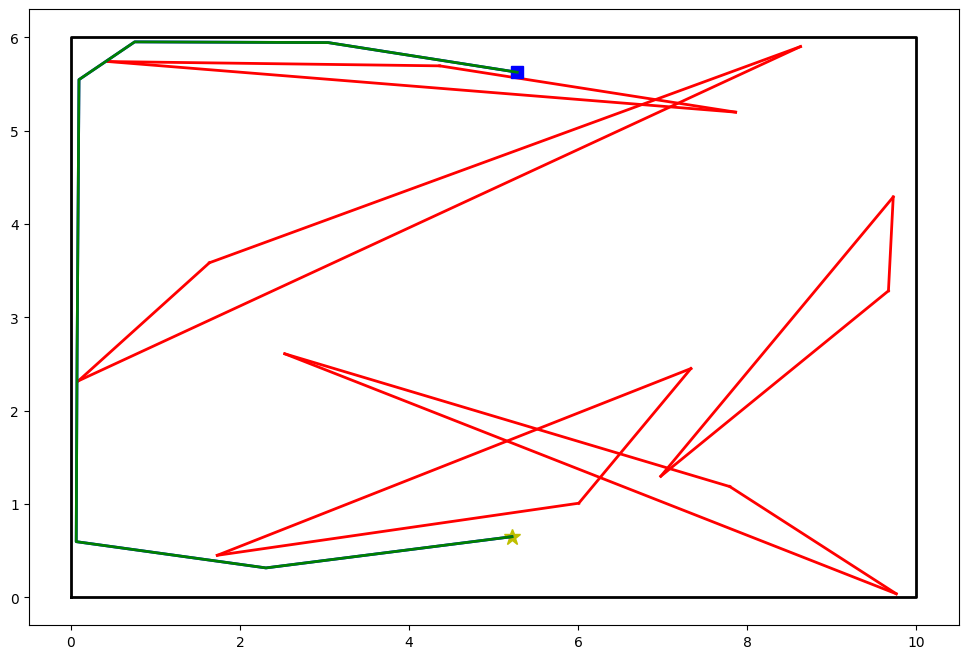

In [39]:
import numpy as np
import pylab as pl
import networkx as nx
from sklearn.neighbors import KDTree
from environment_2d import Environment

# Set up environment
np.random.seed(4)
env = Environment(10, 6, 5)
pl.figure(figsize=(12,8))
pl.clf()
env.plot()
query = env.random_query()

if query is not None:
    x_start, y_start, x_goal, y_goal = query
    env.plot_query(x_start, y_start, x_goal, y_goal)

    # PRM parameters
    num_samples = 500
    connection_radius = 3  # Max distance to connect nodes
    step_size = 0.05  # Smaller step size for finer collision checking
    max_rep = 10  # Number of repetitions for shortcutting

    # Step 1: Generate random nodes
    nodes = []
    while len(nodes) < num_samples:
        x = np.random.rand() * env.size_x
        y = np.random.rand() * env.size_y
        if not env.check_collision(x, y):
            nodes.append((x, y))

    # Convert list of nodes to numpy array for KDTree
    nodes_np = np.array(nodes)

    # Step 2: Build KDTree and find neighbors within the connection radius
    tree = KDTree(nodes_np)
    graph = nx.Graph()
    graph.add_nodes_from(nodes)

    for i, node1 in enumerate(nodes):
        for j, node2 in enumerate(nodes):
            if i != j and np.linalg.norm(np.array(node1) - np.array(node2)) <= connection_radius:
                if is_path_collision_free(node1, node2):
                    graph.add_edge(node1, node2)

    # Step 3: Add start and goal to the graph
    graph.add_node((x_start, y_start))
    graph.add_node((x_goal, y_goal))

    # Connect start and goal nodes to the roadmap
    start_neighbors = tree.query_radius(np.array([[x_start, y_start]]), r=connection_radius)[0]
    goal_neighbors = tree.query_radius(np.array([[x_goal, y_goal]]), r=connection_radius)[0]

    for neighbor in start_neighbors:
        node = nodes[neighbor]
        if is_path_collision_free((x_start, y_start), node):
            graph.add_edge((x_start, y_start), node)

    for neighbor in goal_neighbors:
        node = nodes[neighbor]
        if is_path_collision_free((x_goal, y_goal), node):
            graph.add_edge((x_goal, y_goal), node)

    # Step 4: Path search using A* algorithm
    try:
        path = nx.astar_path(graph, (x_start, y_start), (x_goal, y_goal))
        path_x, path_y = zip(*path)
        pl.plot(path_x, path_y, 'b', linewidth=2)
    except nx.NetworkXNoPath:
        print("No path found between start and goal!")

    # Apply path shortcutting
    path = path_shortcutting(path, max_rep)
    path_x, path_y = zip(*path)
    pl.plot(path_x, path_y, 'g', linewidth=2)

pl.show()

**Other Instances**

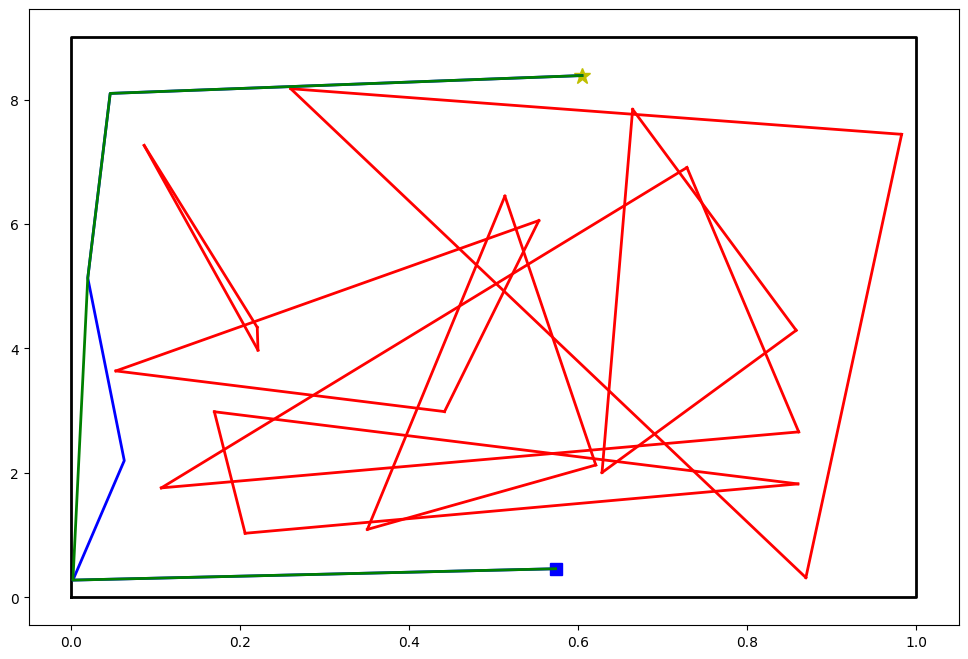

In [49]:
import numpy as np
import pylab as pl
import networkx as nx
from sklearn.neighbors import KDTree
from environment_2d import Environment

# Set up environment
env = Environment(np.random.randint(0, 10), np.random.randint(0, 10), np.random.randint(0, 10))
pl.figure(figsize=(12,8))
pl.clf()
env.plot()
query = env.random_query()

if query is not None:
    x_start, y_start, x_goal, y_goal = query
    env.plot_query(x_start, y_start, x_goal, y_goal)

    # PRM parameters
    num_samples = 500
    connection_radius = 3  # Max distance to connect nodes
    step_size = 0.05  # Smaller step size for finer collision checking
    max_rep = 10  # Number of repetitions for shortcutting

    # Step 1: Generate random nodes
    nodes = []
    while len(nodes) < num_samples:
        x = np.random.rand() * env.size_x
        y = np.random.rand() * env.size_y
        if not env.check_collision(x, y):
            nodes.append((x, y))

    # Convert list of nodes to numpy array for KDTree
    nodes_np = np.array(nodes)

    # Step 2: Build KDTree and find neighbors within the connection radius
    tree = KDTree(nodes_np)
    graph = nx.Graph()
    graph.add_nodes_from(nodes)

    for i, node1 in enumerate(nodes):
        for j, node2 in enumerate(nodes):
            if i != j and np.linalg.norm(np.array(node1) - np.array(node2)) <= connection_radius:
                if is_path_collision_free(node1, node2):
                    graph.add_edge(node1, node2)

    # Step 3: Add start and goal to the graph
    graph.add_node((x_start, y_start))
    graph.add_node((x_goal, y_goal))

    # Connect start and goal nodes to the roadmap
    start_neighbors = tree.query_radius(np.array([[x_start, y_start]]), r=connection_radius)[0]
    goal_neighbors = tree.query_radius(np.array([[x_goal, y_goal]]), r=connection_radius)[0]

    for neighbor in start_neighbors:
        node = nodes[neighbor]
        if is_path_collision_free((x_start, y_start), node):
            graph.add_edge((x_start, y_start), node)

    for neighbor in goal_neighbors:
        node = nodes[neighbor]
        if is_path_collision_free((x_goal, y_goal), node):
            graph.add_edge((x_goal, y_goal), node)

    # Step 4: Path search using A* algorithm
    try:
        path = nx.astar_path(graph, (x_start, y_start), (x_goal, y_goal))
        path_x, path_y = zip(*path)
        pl.plot(path_x, path_y, 'b', linewidth=2)
    except nx.NetworkXNoPath:
        print("No path found between start and goal!")

    # Apply path shortcutting
    path = path_shortcutting(path, max_rep)
    path_x, path_y = zip(*path)
    pl.plot(path_x, path_y, 'g', linewidth=2)

pl.show()

# Blue line indicates the path without shortcutting; green line indicates the path after shortcutting.